In [62]:
'''pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

'''

#Linear algebra
import numpy as np

#Data processing
import pandas as pd

#Data visualization
import seaborn as sns
#matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style


#Algorithms

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import sys
import sklearn
#Getting the data
test = pd.read_csv("test.csv")
train = pd.read_csv('train.csv')
PassengerID = test['PassengerId']


In [63]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print('Size of test:',test.shape)
print('Size of train',train.shape)
print('Column of test:',test.columns)
print('Column of train:',train.columns)


Size of test: (418, 11)
Size of train (891, 12)
Column of test: Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Column of train: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [4]:
print('Python version: {}'.format(sys.version))
print('Numpy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('Seaborn version: {}'.format(sns.__version__))
print('Matplotlib version: {}'.format(matplotlib.__version__))
print('Sklearn version: {}'.format(sklearn.__version__))


Python version: 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
Numpy version: 1.15.4
Pandas version: 0.23.4
Seaborn version: 0.9.0
Matplotlib version: 3.0.2
Sklearn version: 0.20.1


In [5]:
full_data = [train,test]
# Feature that tells whether a passenger had a bin on the Titanic
train['Has Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

#Create a new feature Familysize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['Familysize'] = dataset['SibSp'] + dataset['Parch'] + 1 # Add 1 means include this passenger in its row
    
#Create IsAlone if a passenger didn't travel with family or kin (True or False)
for dataset in full_data:
    dataset['IsAlone'] = 0 # means if Familysize > 1, this passenger travel with family 
    dataset.loc[dataset['Familysize'] == 1, 'IsAlone'] = 1
#Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
#Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train.Fare.median())
train['CategoricalFare'] = pd.qcut(train.Fare, 4)
#Create a new feature CategoricalAge
for dataset in full_data:
    age_ave = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset.Age.isnull().sum()
    age_null_random_list = np.random.randint(age_ave - age_std, age_ave + age_std, size = age_null_count) # Replace a gap that doesn't have a specific age 
    dataset.Age[np.isnan(dataset.Age)] = age_null_random_list
    dataset.Age = dataset.Age.astype(int)
train['CategoricalAge'] = pd.cut(train.Age, 5)
#Extract titles from Passengers's name
for dataset in full_data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
        
#Group all uncommon titles into one single grouping 'Uncommon'    
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Sir','Rev','Major','Lady','Jonkheer','Dr','Don','Countess','Col','Capt'],'Uncommon')
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')


for dataset in full_data:
    #Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female' : 0, 'male' : 1} )
    #Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 1, 'C': 2, 'Q': 3} )
    #Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare']                                 = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454) , 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']    = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare']                                    = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    #Mapping Titles
    title_mapping = {'Master':1, 'Miss':2, 'Mr':3, 'Mrs': 4,'Uncommon':5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    #Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age']                           = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] >64, 'Age']                             = 4


C:\Users\Dung\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
drop_elements = ['PassengerId','Name','Ticket','Cabin','SibSp', 'Parch']
train = train.drop(drop_elements, axis = 1)
train = train.drop(columns = ['CategoricalFare', 'CategoricalAge'])
test  = test.drop(drop_elements, axis = 1) 

In [7]:
train.head(20)

,Survived,Pclass,Sex,Age,Fare,Embarked,Has Cabin,Familysize,IsAlone,Title
0,0,3,1,1,0,1,0,2,0,3
1,1,1,0,2,3,2,1,2,0,4
2,1,3,0,1,1,1,0,1,1,2
3,1,1,0,2,3,1,1,2,0,4
4,0,3,1,2,1,1,0,1,1,3
5,0,3,1,1,1,3,0,1,1,3
6,0,1,1,3,3,1,1,1,1,3
7,0,3,1,0,2,1,0,5,0,1
8,1,3,0,1,1,1,0,3,0,4
9,1,2,0,0,2,2,0,2,0,4


**Pearson Correlation Heatmap**

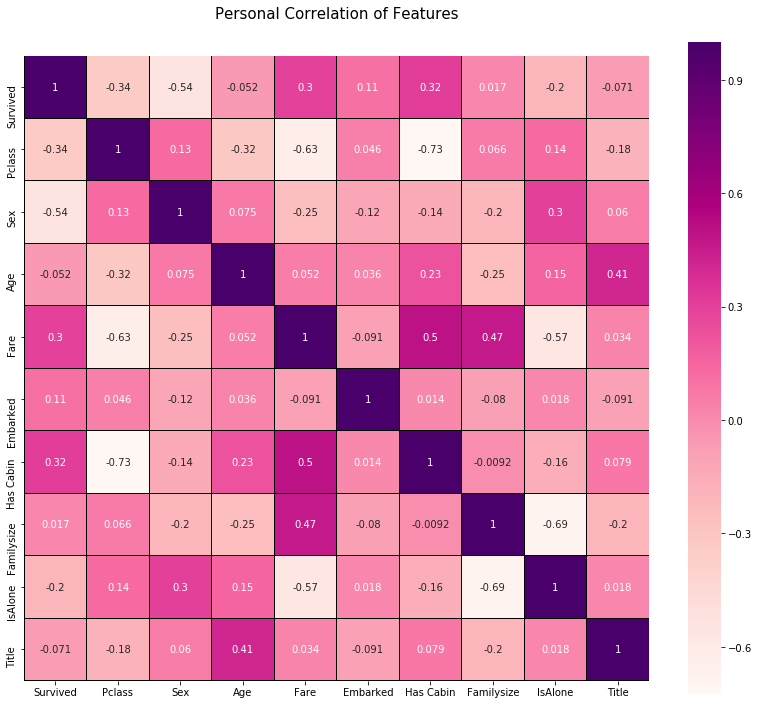

In [8]:
colormap = plt.cm.RdPu #https://matplotlib.org/gallery/color/colormap_reference.html
plt.figure(figsize = (14,12))
plt.title('Personal Correlation of Features', y = 1.05, size = 15)
sns.heatmap(train.astype(float).corr() , linewidth = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor= 'black', annot = True)
plt.show()

**Analyst**

In [9]:
train.info()
print('-'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Sex           891 non-null int64
Age           891 non-null int32
Fare          891 non-null int32
Embarked      891 non-null int64
Has Cabin     891 non-null int64
Familysize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null int64
dtypes: int32(2), int64(8)
memory usage: 62.7 KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
Pclass        418 non-null int64
Sex           418 non-null int64
Age           418 non-null int32
Fare          418 non-null int32
Embarked      418 non-null int64
Has Cabin     418 non-null int64
Familysize    418 non-null int64
IsAlone       418 non-null int64
Title         418 non-null float64
dtypes: float64(1), int32(2), int64(6)
memory usage: 26.2 KB


In [10]:
train.describe()

,Survived,Pclass,Sex,Age,Fare,Embarked,Has Cabin,Familysize,IsAlone,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,1.353535,1.505051,1.361392,0.228956,1.904602,0.602694,2.895623
std,0.486592,0.836071,0.477990,0.841104,1.118148,0.635673,0.420397,1.613459,0.489615,0.788465
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,2.000000
50%,0.000000,3.000000,1.000000,1.000000,2.000000,1.000000,0.000000,1.000000,1.000000,3.000000
75%,1.000000,3.000000,1.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,3.000000
max,1.000000,3.000000,1.000000,4.000000,3.000000,3.000000,1.000000,11.000000,1.000000,5.000000


In [11]:
# the upper-class passengers were most likely survived 
train[['Pclass','Survived']].groupby(['Pclass'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [12]:
# the female passengers had very high rate survival rate at 74%
train[['Sex','Survived']].groupby(['Sex'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,0,0.742038
1,1,0.188908


In [13]:
train[['Familysize','Survived']].groupby(['Familysize'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Familysize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


**Analyst by Visualizing data**

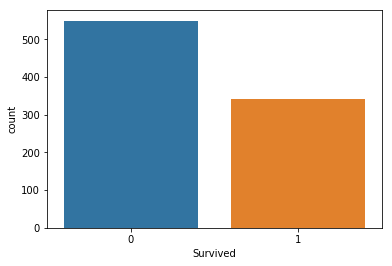

In [14]:
sns.countplot(x = 'Survived', data = train)
plt.show()

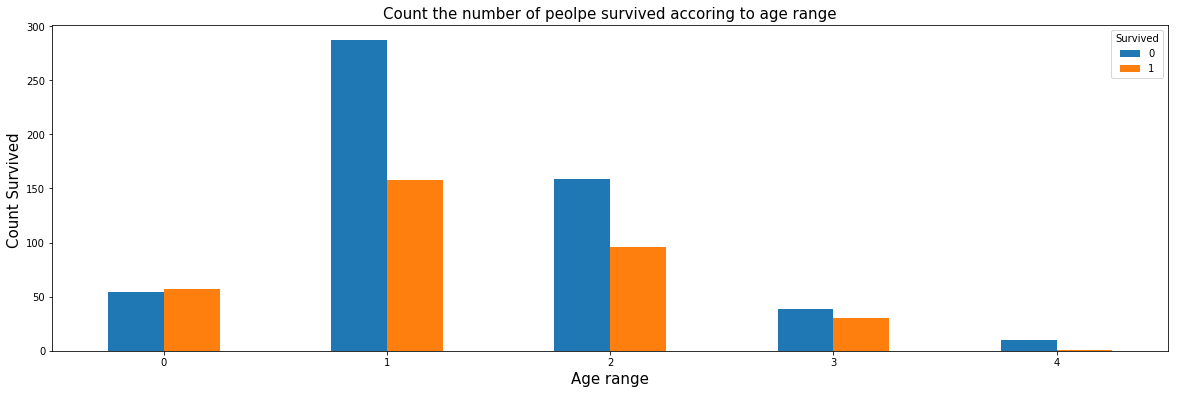

In [15]:
pd.crosstab(train.Age, train.Survived).plot(kind = 'bar', figsize = (20,6))
plt.title('Count the number of peolpe survived accoring to age range',size = 15)
plt.ylabel('Count Survived ',fontsize = 15)
plt.xlabel('Age range', fontsize = 15)
plt.xticks(rotation = 0)
plt.show()

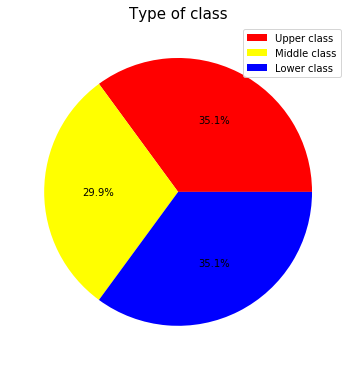

In [16]:
upperclass = train[train.Pclass == 1]
middleclass = train[train.Pclass == 2]
lowerclass = train[train.Pclass == 3]
colors = ['red','yellow','blue']
explode = [0,0,0]
plt.figure(figsize = (6,9))
plt.pie([len(upperclass),len(middleclass),len(upperclass)], colors = colors, explode = explode, autopct = '%1.1f%%')
plt.title('Type of class', size = 15)
plt.legend(['Upper class', 'Middle class', 'Lower class'], loc = 'best')
plt.show()

C:\Users\Dung\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


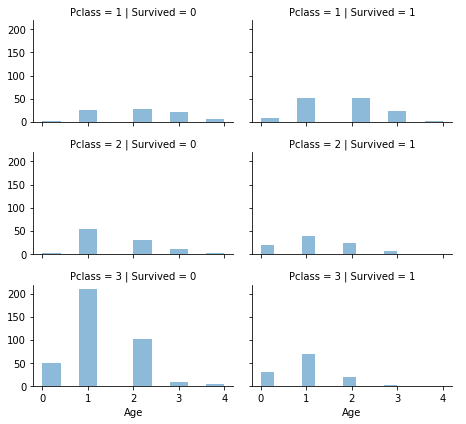

In [17]:
grid = sns.FacetGrid(train, col = 'Survived', row = 'Pclass', size = 2, aspect = 1.6)
grid.map(plt.hist, 'Age', alpha = .5)
grid.add_legend()

C:\Users\Dung\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Dung\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Dung\Anaconda3\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Dung\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / s

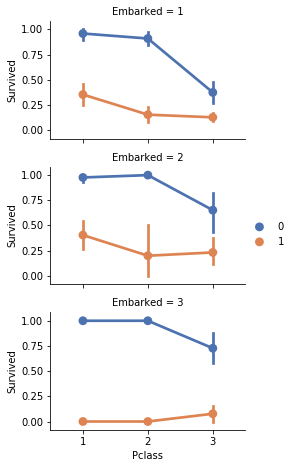

In [18]:
grid = sns.FacetGrid(train, row = 'Embarked', size = 2.2, aspect = 1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'deep')
grid.add_legend()

In [19]:
train.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,Has Cabin,Familysize,IsAlone,Title
0,0,3,1,1,0,1,0,2,0,3
1,1,1,0,2,3,2,1,2,0,4
2,1,3,0,1,1,1,0,1,1,2
3,1,1,0,2,3,1,1,2,0,4
4,0,3,1,2,1,1,0,1,1,3


In [20]:
survived_male = len(train[(train.Sex == 1) & (train.Survived == 1)])
survived_female = len(train[(train.Sex == 0) & (train.Survived == 1)])

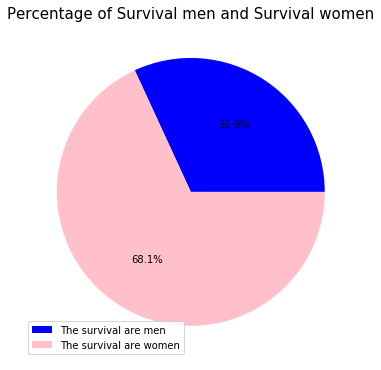

In [21]:
colors = ['blue','pink']
explode = [0,0]
plt.figure(figsize = (6,9))
plt.pie(x = [survived_male,survived_female],colors = colors, explode = explode, autopct = '%1.1f%%')
plt.legend(labels=['The survival are men','The survival are women'], loc = 'lower left')
plt.title('Percentage of Survival men and Survival women',fontsize = 15)
plt.show()

C:\Users\Dung\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Dung\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


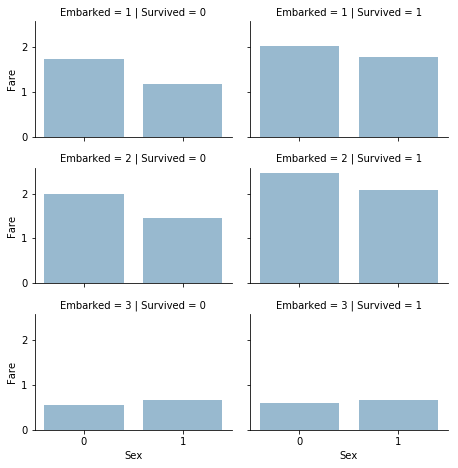

In [22]:
grid = sns.FacetGrid(train, row = 'Embarked', col = 'Survived', aspect = 1.5,size = 2.2)
grid.map(sns.barplot, 'Sex', 'Fare',alpha = 0.5, ci = None)
plt.show()

**Wrangle data**

In [23]:
train.head(10)


,Survived,Pclass,Sex,Age,Fare,Embarked,Has Cabin,Familysize,IsAlone,Title
0,0,3,1,1,0,1,0,2,0,3
1,1,1,0,2,3,2,1,2,0,4
2,1,3,0,1,1,1,0,1,1,2
3,1,1,0,2,3,1,1,2,0,4
4,0,3,1,2,1,1,0,1,1,3
5,0,3,1,1,1,3,0,1,1,3
6,0,1,1,3,3,1,1,1,1,3
7,0,3,1,0,2,1,0,5,0,1
8,1,3,0,1,1,1,0,3,0,4
9,1,2,0,0,2,2,0,2,0,4


C:\Users\Dung\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


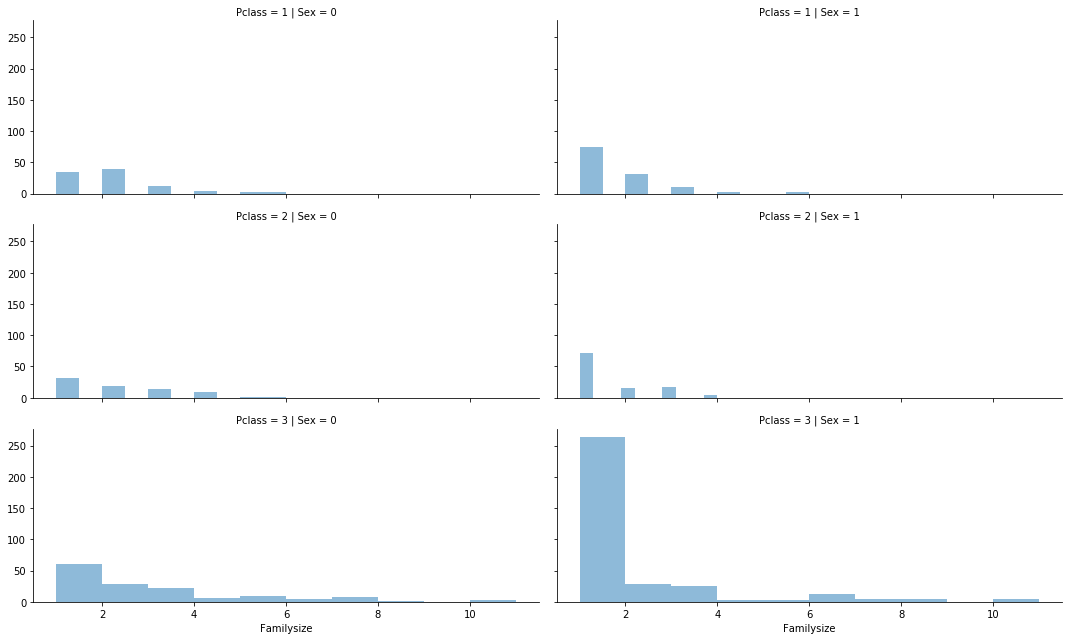

In [24]:
grid = sns.FacetGrid(train, row = 'Pclass' , col = 'Sex', aspect = 2.5, size = 3)
grid.map(plt.hist, 'Familysize', alpha = .5)
plt.show()

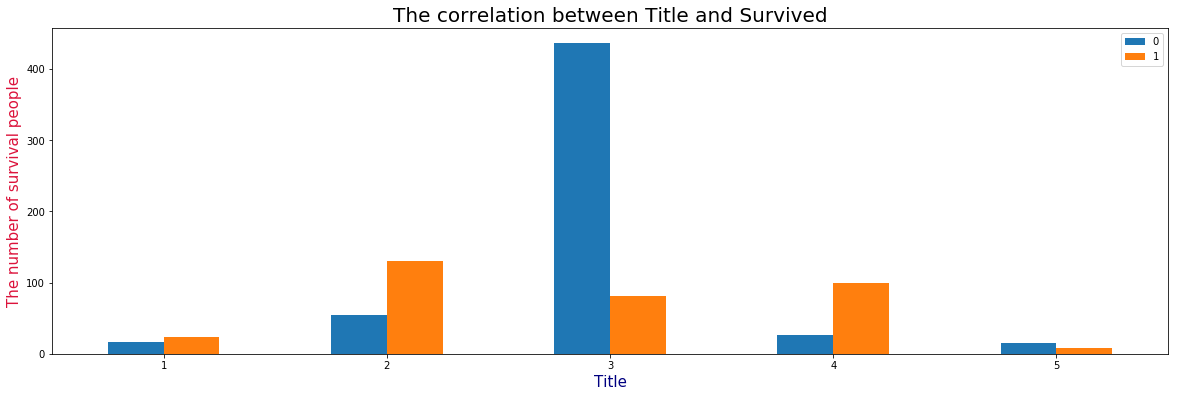

In [25]:
pd.crosstab(train.Title, train.Survived).plot(kind = 'bar', figsize = (20,6))
plt.title('The correlation between Title and Survived',fontsize = 20)
plt.xlabel('Title',fontsize = 15, color = 'navy')
plt.xticks(rotation=0)
plt.legend()
plt.ylabel('The number of survival people', fontsize = 15, color = 'crimson')
plt.show()

**Spliting the data**

In [26]:
x_train = train.drop('Survived', axis =1 )
y_train = train['Survived']
x_test = test.copy()
x_train.shape , y_train.shape, x_test.shape

((891, 9), (891,), (418, 9))

**Logistic Regression**

In [40]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
Y_pred = logreg.predict(x_test)
acc_log = round(logreg.score(x_train, y_train) * 100, 2)
print('Test accuracy of Logistic Regression is: {}%'.format(acc_log))

Test accuracy of Logistic Regression is: 80.47%


C:\Users\Dung\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [29]:
coeff = pd.DataFrame(train.columns.delete(0))
coeff.columns = ['Feature']
coeff['Correlation'] = pd.Series(logreg.coef_[0])
coeff.sort_values(by = 'Correlation', ascending = False)

,Feature,Correlation
5,Has Cabin,0.768038
3,Fare,0.354143
4,Embarked,0.315338
8,Title,-0.160157
6,Familysize,-0.377858
2,Age,-0.381819
7,IsAlone,-0.397836
0,Pclass,-0.428724
1,Sex,-2.462873


**K-Nearest Neighbors**



In [42]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
Y_pred = knn.predict(x_test)
acc_knn = round(knn.score(x_train, y_train) * 100, 2)
print('Test accuracy of K-Nearest Neighbors is: {}%'.format(acc_knn))

Test accuracy of K-Nearest Neighbors is: 85.52%


**Support Vector Machine**

In [58]:
svc = SVC()
svc.fit(x_train, y_train)
Y_pred = svc.predict(x_test)
acc_svc = round(svc.score(x_train, y_train) * 100, 3)
print('Test accuracy of Support Vector Machine is: {}%'.format(acc_svc))

Test accuracy of Support Vector Machine is: 83.502%


C:\Users\Dung\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


**Naive Bayes**

In [44]:
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
Y_pred = gaussian.predict(x_test)
acc_gaussian = round(gaussian.score(x_train, y_train) * 100, 2)
print('Test accuracy of Naive Bayes is: {}%'.format(acc_gaussian))

Test accuracy of Naive Bayes is: 80.47%


**Perceptron**

In [57]:
perceptron = Perceptron()
perceptron.fit(x_train, y_train)
Y_pred = perceptron.predict(x_test)
acc_perceptron = round(perceptron.score(x_train, y_train) * 100, 2)
print('Test accuracy of Perceptron is: {}%'.format(acc_perceptron))

Test accuracy of Perceptron is: 78.0%


C:\Users\Dung\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


**Linear SVC**

In [56]:
linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
Y_pred = linear_svc.predict(x_test)
acc_linear_svc = round(linear_svc.score(x_train, y_train) * 100, 2)
print('Test accuracy of Linear SVC is: {}%'.format(acc_linear_svc))

Test accuracy of Linear SVC is: 80.13%


C:\Users\Dung\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


**Stochastic Gradient Descent**

In [55]:
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
Y_pred = sgd.predict(x_test)
acc_sgd = round(sgd.score(x_train, y_train) * 100, 2)
print('Test accuracy of Stochastic Gradient Descent is: {}%'.format(acc_sgd))

Test accuracy of Stochastic Gradient Descent is: 75.76%


C:\Users\Dung\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


**Decision Tree**

In [54]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
Y_pred = decision_tree.predict(x_test)
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print('Test accuracy of Decision Tree is: {}%'.format(acc_decision_tree))

Test accuracy of Decision Tree is: 89.67%


**Random Forest**

In [53]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)
Y_pred = random_forest.predict(x_test)
random_forest.score(x_train, y_train)
acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)
print('Test accuracy of Random Forest is: {}%'.format(acc_random_forest))

Test accuracy of Random Forest is: 89.67%


**Algorithms's Visuallize**

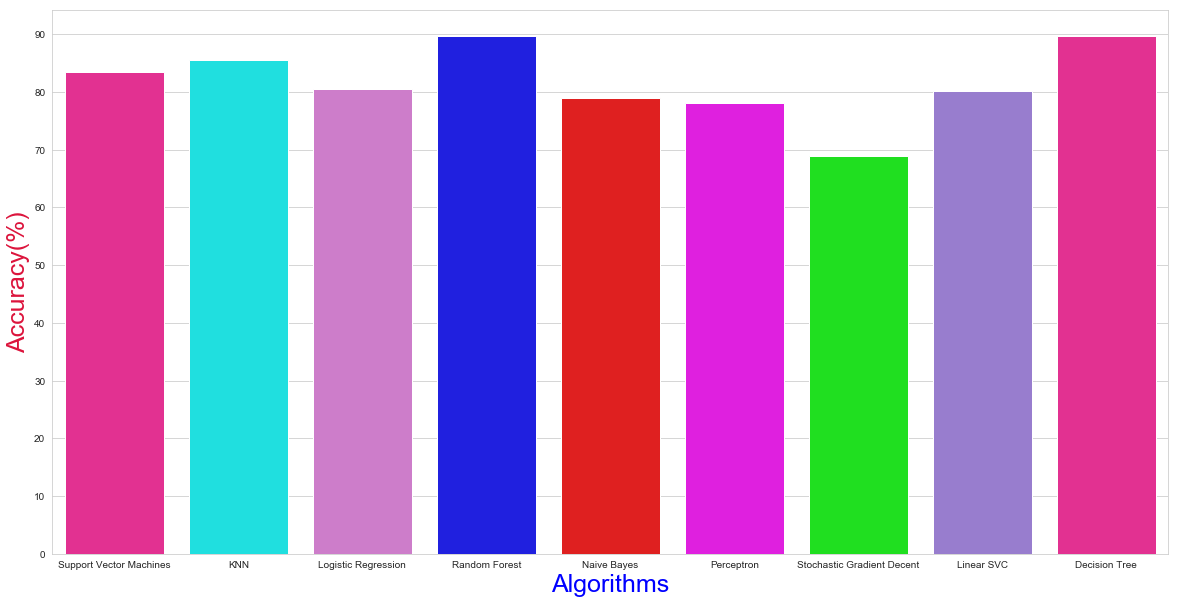

In [38]:
Model = ['Support Vector Machines', 'KNN', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'Perceptron',  'Stochastic Gradient Decent', 'Linear SVC', 'Decision Tree']
score = [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]
colors = ["deeppink", "cyan", "orchid", 'blue','r',"magenta","lime","mediumpurple"]
sns.set_style('whitegrid')
plt.figure(figsize = (20,10))
sns.barplot(x = Model, y = score, palette = colors)
plt.yticks(np.arange(0,100,10))
plt.xlabel('Algorithms',fontsize = 25, color = 'blue')
plt.ylabel('Accuracy(%)',fontsize = 25, color = 'crimson')
plt.show()